# 指静脉识别

## 导入数据集

### 导入包

In [60]:
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import gluon
from mxnet.gluon.data import vision
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data import DataLoader
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon import nn
from mxnet import init
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from scipy import misc
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [61]:
transform_train = transforms.Compose([
#     transforms.RandomFlipLeftRight(),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomBrightness(0.1), 
#     transforms.RandomContrast(0.1), 
    transforms.Resize(224), 
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [62]:
# transforms.RandomContrast??

In [63]:
data_dir = './data/PolyU/'
batch_size = 8

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = DataLoader(train_ds.transform_first(transform_train), 
                        batch_size, shuffle=True, last_batch='keep')
valid_data = DataLoader(valid_ds.transform_first(transform_valid), 
                        batch_size, shuffle=False, last_batch='keep')

In [64]:
print(len(train_ds))

print(len(train_data))
for data, label in train_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

936
117
(8, 3, 224, 224) (8,)

[ 23 268 233 290 204  93 224 242]
<NDArray 8 @gpu(0)>


## softmax loss

In [65]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## center loss

In [66]:
class CenterLoss(gluon.HybridBlock):
    r"""
    Center Loss: A Discriminative Feature Learning Approach for Deep Face Recognition
    """
    def __init__(self, num_classes, feature_size, lmbd, **kwargs):
        super(CenterLoss, self).__init__(**kwargs)
        self._num_classes = num_classes
        self._feature_size = feature_size
        self._lmda = lmbd
        self.centers = self.params.get('centers', shape=(num_classes, feature_size))

    def hybrid_forward(self, F, feature, label, centers):
        hist = F.array(np.bincount(label.asnumpy().astype(int)))
        centers_count = F.take(hist, label)
        centers_selected = F.take(centers, label)
        diff = feature - centers_selected
        loss = self._lmda * 0.5 * F.sum(F.square(diff), 1) / centers_count
        return F.mean(loss, axis=0, exclude=True)

In [67]:
center_loss = CenterLoss(num_classes=312, feature_size=1792, lmbd=0.2) #lmbd = 0.2 99.4595

## triplet loss

In [68]:
# triplet_loss = gluon.loss.TripletLoss()

In [69]:
# gluon.loss.TripletLoss??

## 定义模型 --FingerveinNet

In [70]:
class block_35(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_35, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=3, 
                                   strides=1, padding=1))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            branch_3 = nn.HybridSequential()
            branch_3.add(nn.Conv2D(channels=channels[3], kernel_size=1, 
                                   strides=1, padding=0))
            branch_3.add(nn.BatchNorm())
            branch_3.add(nn.Activation(activation='relu'))
            branch_3.add(nn.Conv2D(channels=channels[4], kernel_size=5, 
                                   strides=1, padding=2))
            branch_3.add(nn.BatchNorm())
            branch_3.add(nn.Activation(activation='relu'))
            
#             branch_4 = nn.HybridSequential()
#             branch_4.add(nn.MaxPool2D(pool_size=3, strides=1, padding=1))
#             branch_4.add(nn.Conv2D(channels=channels[5], kernel_size=1, 
#                                    strides=1, padding=0))
            
            self.up = nn.Conv2D(channels=channels[6], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
        self.branch_3 = branch_3
#         self.branch_4 = branch_4
    
    def hybrid_forward(self, F, x):
        out1 = out2 = out3 = out4 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        for layer in self.branch_3:
            out3 = layer(out3)
#         for layer in self.branch_4:
#             out4 = layer(out4)
#         mixed = F.concat(out1, out2, out3, out4, dim=1)
        mixed = F.concat(out1, out2, out3, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [71]:
class block_17(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_17, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=(1, 7), 
                                   strides=1, padding=(0, 3)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[3], kernel_size=(7, 1), 
                                   strides=1, padding=(3, 0)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            self.up = nn.Conv2D(channels=channels[4], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
    
    def hybrid_forward(self, F, x):
        out1 = out2 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        mixed = F.concat(out1, out2, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [72]:
class block_13(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(block_13, self).__init__(**kwargs)
        with self.name_scope():
            branch_1 = nn.HybridSequential()
            branch_1.add(nn.Conv2D(channels=channels[0], kernel_size=1, 
                                   strides=1, padding=0))
            branch_1.add(nn.BatchNorm())
            branch_1.add(nn.Activation(activation='relu'))
            
            branch_2 = nn.HybridSequential()
            branch_2.add(nn.Conv2D(channels=channels[1], kernel_size=1, 
                                   strides=1, padding=0))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[2], kernel_size=(1, 3), 
                                   strides=1, padding=(0, 1)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            branch_2.add(nn.Conv2D(channels=channels[3], kernel_size=(3, 1), 
                                   strides=1, padding=(1, 0)))
            branch_2.add(nn.BatchNorm())
            branch_2.add(nn.Activation(activation='relu'))
            
            self.up = nn.Conv2D(channels=channels[4], kernel_size=1, 
                                strides=1, padding=0)
            
            self.bn = nn.BatchNorm()
            
        self.branch_1 = branch_1
        self.branch_2 = branch_2
    
    def hybrid_forward(self, F, x):
        out1 = out2 = x
        for layer in self.branch_1:
            out1 = layer(out1)
        for layer in self.branch_2:
            out2 = layer(out2)
        mixed = F.concat(out1, out2, dim=1)
        up = self.up(mixed)
            
        out = F.relu(self.bn(up + x))
        
        return out

In [73]:
class FingerveinNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(FingerveinNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            features = nn.HybridSequential()
            # Stage 1
            features.add(nn.Conv2D(channels=64, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.Conv2D(channels=192, kernel_size=3, 
                              strides=2, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
#             features.add(nn.Dropout(0.2))
            # Stage 2
            features.add(nn.Conv2D(channels=64, kernel_size=1, 
                              strides=1, padding=0))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.Conv2D(channels=256, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
#             features.add(nn.Dropout(0.2))
            # Stage 3
            features.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
#             net.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
#             net.add(block_35(channels=[32, 32, 32, 32, 32, 32, 256]))
            features.add(nn.Conv2D(channels=896, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
#             features.add(nn.Dropout(0.2))
            # Stage 4
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(block_17(channels=[128, 128, 128, 128, 896]))
#             net.add(block_17(channels=[128, 128, 128, 128, 896]))
#             net.add(block_17(channels=[128, 128, 128, 128, 896]))
            features.add(nn.Conv2D(channels=1792, kernel_size=3, 
                              strides=1, padding=1))
            features.add(nn.BatchNorm())
            features.add(nn.Activation(activation='relu'))
            features.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
#             features.add(nn.Dropout(0.2))
            # Stage 5
            features.add(block_13(channels=[192, 192, 192, 192, 1792]))
#             net.add(block_13(channels=[192, 192, 192, 192, 1792]))
#             net.add(block_13(channels=[192, 192, 192, 192, 1792]))
            features.add(nn.AvgPool2D(pool_size=7, strides=1, padding=0))
            # classification
            features.add(nn.Dropout(0.2))
            features.add(nn.Flatten())
            
            output = nn.Dense(num_classes)
        
        self.features = features
        self.output = output
        
    def hybrid_forward(self, F, x):
        for i, layer in enumerate(self.features):
            feat = layer(x)
            x = feat
            if self.verbose:
                print('Block %d, Output: %s' % (i+1, out.shape))
        out = self.output(feat)
        return out, feat

In [74]:
def get_net(ctx, num_classes=100):
    net = FingerveinNet(num_classes)
#     net = ResNet(num_classes)
#     net = ResNet50(num_classes)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [16]:
FingerveinNet(num_classes=312, verbose=True)

FingerveinNet(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): Conv2D(None -> 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (5): Activation(relu)
    (6): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (7): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1))
    (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (9): Activation(relu)
    (10): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (12): Activation(relu)
    (13): MaxPool2D(

## softmax loss trainning

In [75]:
def train_softmax(train_data, valid_data, net, ctx, num_epoches, 
          learning_rate=0.01, lr_decay=0.1, lr_period=50, 
          momentum = 0.9, weight_decay=0, cost_period = 10, 
          print_cost=False):
    costs = []
    max_acc = 0
#     trainer = gluon.Trainer(net.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate})
    pre_time = datetime.datetime.now()
#     moving_loss = 0
#     niter = 0
    for epoch in range(num_epoches):
        train_loss = 0
        train_acc = 0
        if (epoch+1) in lr_period:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            data = data.as_in_context(ctx)
#             label = label.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output, features = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
#             print(output.argmax(axis=1).astype(np.int64), label)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
#             niter += 1
#             cur_loss = nd.mean(loss).asscalar()
#             moving_loss = 0.9 * moving_loss + 0.1 * cur_loss
#             corr_loss = moving_loss / (1 - pow(0.9, niter))
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_acc = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
#                 label = label.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output, features = net(data)
#                 valid_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
            if valid_acc > max_acc:
                net.save_params('fingervein_weight_softmax_PolyU_new.txt')
                max_acc = valid_acc
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, valid_acc %f, " % (epoch+1, 
                                                                                   train_loss/len(train_data), 
                                                                                   train_acc/len(train_data), 
                                                                                   valid_acc/len(valid_data))
        else:
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, " % (epoch+1, 
                                                                     train_loss/len(train_data), 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_period == 0:
#             costs.append(corr_loss)
            costs.append(train_loss/len(train_data))
        print(epoch_str + time_str + ', lr: %f' % trainer.learning_rate)
        pre_time = cur_time
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(costs), endpoint = True)
        plt.semilogy(x_axis, costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig('train_softmax_loss_PolyU_new.png')
        plt.show()

## center loss trainning

In [18]:
def train_center(train_data, valid_data, net, ctx, num_epoches, 
          learning_rate=0.01, lr_decay=0.1, lr_period=50, lr_set=[0.001, 0.0001, 0.0001], 
          momentum = 0.9, weight_decay=0, cost_period = 10, 
          print_cost=False):
    costs = []
    max_acc = 0
#     trainer = gluon.Trainer(net.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    
    center_loss.initialize(mx.init.Xavier(), ctx=ctx)
    trainer_center = gluon.Trainer(center_loss.collect_params(), 'adam', 
                                   {'learning_rate': learning_rate})
#     trainer_center = gluon.Trainer(center_loss.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate})
    pre_time = datetime.datetime.now()
#     moving_loss = 0
#     niter = 0
    for epoch in range(num_epoches):
        train_loss = 0
        train_acc = 0
        count = 0
        if (epoch+1) in lr_period:
#             trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            trainer.set_learning_rate(lr_set[count])
            count += 1
        for data, label in train_data:
            data = data.as_in_context(ctx)
#             label = label.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output, features = net(data)
#                 loss = softmax_cross_entropy(output, label)
                loss_softmax = softmax_cross_entropy(output, label)
                loss_center = center_loss(features, label)
                loss = loss_softmax + loss_center
            loss.backward()
            trainer.step(batch_size)
            trainer_center.step(batch_size)
#             loss.backward()
#             trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
#             print(output.argmax(axis=1).astype(np.int64), label)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
#             niter += 1
#             cur_loss = nd.mean(loss).asscalar()
#             moving_loss = 0.9 * moving_loss + 0.1 * cur_loss
#             corr_loss = moving_loss / (1 - pow(0.9, niter))
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_acc = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
#                 label = label.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output, features = net(data)
#                 valid_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
            if valid_acc >= max_acc:
                net.save_params('fingervein_weight_centerloss_PolyU_new.txt')
                max_acc = valid_acc
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, valid_acc %f, " % (epoch+1, 
                                                                                   train_loss/len(train_data), 
                                                                                   train_acc/len(train_data), 
                                                                                   valid_acc/len(valid_data))
        else:
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, " % (epoch+1, 
                                                                     train_loss/len(train_data), 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_period == 0:
#             costs.append(corr_loss)
            costs.append(train_loss/len(train_data))
        print(epoch_str + time_str + ', lr: %f' % trainer.learning_rate)
        pre_time = cur_time
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(costs), endpoint = True)
        plt.semilogy(x_axis, costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig('train_center_loss_PolyU_new.png')
        plt.show()

In [76]:
# valid_data = None
ctx = mx.gpu(0)
num_epoches = 300
learning_rate = 0.001
lr_decay = 0.3
lr_period = [80, 130, 200, 250]
lr_set = [0.0003, 0.0001, 0.00003, 0.00001]
# lr_period = [50, 100, 150, 200]
momentum = 0.9
weight_decay = 5e-4
cost_period = 10

## 从头训练

Epoch 1, train_loss: 8.198749, train_acc: 0.001068, valid_acc 0.004274, Time 00:00:09, lr: 0.001000
Epoch 2, train_loss: 5.893004, train_acc: 0.003205, valid_acc 0.007479, Time 00:00:11, lr: 0.001000
Epoch 3, train_loss: 5.771493, train_acc: 0.003205, valid_acc 0.005342, Time 00:00:12, lr: 0.001000
Epoch 4, train_loss: 5.707734, train_acc: 0.004274, valid_acc 0.013889, Time 00:00:11, lr: 0.001000
Epoch 5, train_loss: 5.628729, train_acc: 0.005342, valid_acc 0.009615, Time 00:00:11, lr: 0.001000
Epoch 6, train_loss: 5.511315, train_acc: 0.005342, valid_acc 0.011752, Time 00:00:11, lr: 0.001000
Epoch 7, train_loss: 5.405708, train_acc: 0.008547, valid_acc 0.022436, Time 00:00:11, lr: 0.001000
Epoch 8, train_loss: 5.306376, train_acc: 0.009615, valid_acc 0.043803, Time 00:00:11, lr: 0.001000
Epoch 9, train_loss: 5.168488, train_acc: 0.020299, valid_acc 0.070513, Time 00:00:11, lr: 0.001000
Epoch 10, train_loss: 5.018629, train_acc: 0.045940, valid_acc 0.114316, Time 00:00:11, lr: 0.001000

Epoch 83, train_loss: 0.100160, train_acc: 1.000000, valid_acc 0.978632, Time 00:00:11, lr: 0.000300
Epoch 84, train_loss: 0.098358, train_acc: 1.000000, valid_acc 0.980769, Time 00:00:11, lr: 0.000300
Epoch 85, train_loss: 0.098081, train_acc: 1.000000, valid_acc 0.975427, Time 00:00:11, lr: 0.000300
Epoch 86, train_loss: 0.100053, train_acc: 1.000000, valid_acc 0.978632, Time 00:00:11, lr: 0.000300
Epoch 87, train_loss: 0.098129, train_acc: 1.000000, valid_acc 0.980769, Time 00:00:11, lr: 0.000300
Epoch 88, train_loss: 0.095692, train_acc: 1.000000, valid_acc 0.980769, Time 00:00:11, lr: 0.000300
Epoch 89, train_loss: 0.094050, train_acc: 1.000000, valid_acc 0.979701, Time 00:00:11, lr: 0.000300
Epoch 90, train_loss: 0.091962, train_acc: 1.000000, valid_acc 0.982906, Time 00:00:11, lr: 0.000300
Epoch 91, train_loss: 0.091185, train_acc: 1.000000, valid_acc 0.980769, Time 00:00:11, lr: 0.000300
Epoch 92, train_loss: 0.089859, train_acc: 1.000000, valid_acc 0.980769, Time 00:00:11, lr:

Epoch 164, train_loss: 0.028135, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 165, train_loss: 0.027887, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 166, train_loss: 0.027255, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 167, train_loss: 0.026757, train_acc: 1.000000, valid_acc 0.987179, Time 00:00:11, lr: 0.000300
Epoch 168, train_loss: 0.026295, train_acc: 1.000000, valid_acc 0.986111, Time 00:00:11, lr: 0.000300
Epoch 169, train_loss: 0.025765, train_acc: 1.000000, valid_acc 0.989316, Time 00:00:11, lr: 0.000300
Epoch 170, train_loss: 0.025447, train_acc: 1.000000, valid_acc 0.987179, Time 00:00:11, lr: 0.000300
Epoch 171, train_loss: 0.024786, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 172, train_loss: 0.024469, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 173, train_loss: 0.024332, train_acc: 1.000000, valid_acc 0.989316, Time 00:

Epoch 245, train_loss: 0.009440, train_acc: 1.000000, valid_acc 0.990385, Time 00:00:11, lr: 0.000300
Epoch 246, train_loss: 0.009533, train_acc: 1.000000, valid_acc 0.991453, Time 00:00:11, lr: 0.000300
Epoch 247, train_loss: 0.009378, train_acc: 1.000000, valid_acc 0.991453, Time 00:00:11, lr: 0.000300
Epoch 248, train_loss: 0.009131, train_acc: 1.000000, valid_acc 0.990385, Time 00:00:11, lr: 0.000300
Epoch 249, train_loss: 0.009042, train_acc: 1.000000, valid_acc 0.991453, Time 00:00:11, lr: 0.000300
Epoch 250, train_loss: 0.010479, train_acc: 1.000000, valid_acc 0.983974, Time 00:00:11, lr: 0.000300
Epoch 251, train_loss: 0.011148, train_acc: 1.000000, valid_acc 0.988248, Time 00:00:11, lr: 0.000300
Epoch 252, train_loss: 0.009485, train_acc: 1.000000, valid_acc 0.991453, Time 00:00:11, lr: 0.000300
Epoch 253, train_loss: 0.008959, train_acc: 1.000000, valid_acc 0.990385, Time 00:00:11, lr: 0.000300
Epoch 254, train_loss: 0.008752, train_acc: 1.000000, valid_acc 0.990385, Time 00:

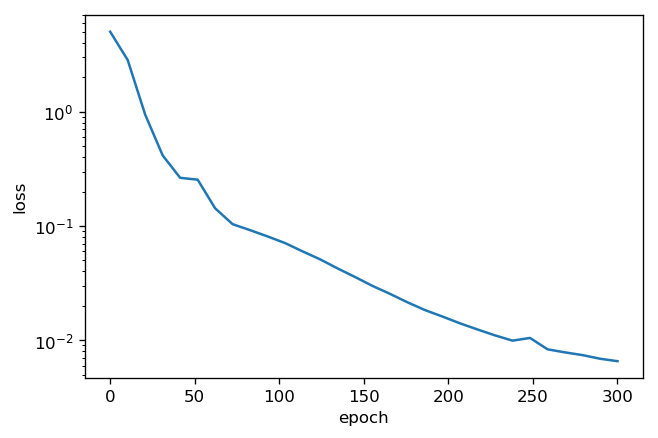

In [21]:
net = get_net(ctx, num_classes=312)
net.hybridize()
train_center(train_data, valid_data, net, ctx, num_epoches, 
      learning_rate, lr_decay, lr_period, lr_set, 
      momentum, weight_decay, cost_period, 
      print_cost=True)

Epoch 1, train_loss: 6.432601, train_acc: 0.001068, valid_acc 0.016026, Time 00:00:07, lr: 0.001000
Epoch 2, train_loss: 5.653132, train_acc: 0.004274, valid_acc 0.029915, Time 00:00:11, lr: 0.001000
Epoch 3, train_loss: 5.343450, train_acc: 0.008547, valid_acc 0.039530, Time 00:00:11, lr: 0.001000
Epoch 4, train_loss: 5.002775, train_acc: 0.025641, valid_acc 0.050214, Time 00:00:11, lr: 0.001000
Epoch 5, train_loss: 4.766012, train_acc: 0.030983, valid_acc 0.061966, Time 00:00:12, lr: 0.001000
Epoch 6, train_loss: 4.451768, train_acc: 0.043803, valid_acc 0.073718, Time 00:00:11, lr: 0.001000
Epoch 7, train_loss: 4.167762, train_acc: 0.085470, valid_acc 0.108974, Time 00:00:11, lr: 0.001000
Epoch 8, train_loss: 3.862967, train_acc: 0.104701, valid_acc 0.195513, Time 00:00:11, lr: 0.001000
Epoch 9, train_loss: 3.525649, train_acc: 0.158120, valid_acc 0.230769, Time 00:00:11, lr: 0.001000
Epoch 10, train_loss: 3.209255, train_acc: 0.207265, valid_acc 0.304487, Time 00:00:11, lr: 0.001000

Epoch 83, train_loss: 0.012723, train_acc: 0.998932, valid_acc 0.920940, Time 00:00:11, lr: 0.000300
Epoch 84, train_loss: 0.003653, train_acc: 1.000000, valid_acc 0.924145, Time 00:00:10, lr: 0.000300
Epoch 85, train_loss: 0.002317, train_acc: 1.000000, valid_acc 0.931624, Time 00:00:10, lr: 0.000300
Epoch 86, train_loss: 0.002456, train_acc: 1.000000, valid_acc 0.925214, Time 00:00:11, lr: 0.000300
Epoch 87, train_loss: 0.001777, train_acc: 1.000000, valid_acc 0.927350, Time 00:00:10, lr: 0.000300
Epoch 88, train_loss: 0.001352, train_acc: 1.000000, valid_acc 0.930556, Time 00:00:11, lr: 0.000300
Epoch 89, train_loss: 0.001419, train_acc: 1.000000, valid_acc 0.938034, Time 00:00:11, lr: 0.000300
Epoch 90, train_loss: 0.001439, train_acc: 1.000000, valid_acc 0.931624, Time 00:00:11, lr: 0.000300
Epoch 91, train_loss: 0.007436, train_acc: 0.997863, valid_acc 0.920940, Time 00:00:11, lr: 0.000300
Epoch 92, train_loss: 0.002732, train_acc: 1.000000, valid_acc 0.935897, Time 00:00:11, lr:

Epoch 164, train_loss: 0.000116, train_acc: 1.000000, valid_acc 0.938034, Time 00:00:11, lr: 0.000090
Epoch 165, train_loss: 0.001147, train_acc: 0.998932, valid_acc 0.944444, Time 00:00:10, lr: 0.000090
Epoch 166, train_loss: 0.000225, train_acc: 1.000000, valid_acc 0.945513, Time 00:00:10, lr: 0.000090
Epoch 167, train_loss: 0.000459, train_acc: 1.000000, valid_acc 0.945513, Time 00:00:10, lr: 0.000090
Epoch 168, train_loss: 0.000138, train_acc: 1.000000, valid_acc 0.946581, Time 00:00:11, lr: 0.000090
Epoch 169, train_loss: 0.000361, train_acc: 1.000000, valid_acc 0.944444, Time 00:00:10, lr: 0.000090
Epoch 170, train_loss: 0.000256, train_acc: 1.000000, valid_acc 0.945513, Time 00:00:10, lr: 0.000090
Epoch 171, train_loss: 0.000120, train_acc: 1.000000, valid_acc 0.946581, Time 00:00:10, lr: 0.000090
Epoch 172, train_loss: 0.000143, train_acc: 1.000000, valid_acc 0.941239, Time 00:00:10, lr: 0.000090
Epoch 173, train_loss: 0.000193, train_acc: 1.000000, valid_acc 0.943376, Time 00:

Epoch 245, train_loss: 0.000027, train_acc: 1.000000, valid_acc 0.950855, Time 00:00:10, lr: 0.000027
Epoch 246, train_loss: 0.000059, train_acc: 1.000000, valid_acc 0.949786, Time 00:00:10, lr: 0.000027
Epoch 247, train_loss: 0.000051, train_acc: 1.000000, valid_acc 0.949786, Time 00:00:10, lr: 0.000027
Epoch 248, train_loss: 0.000028, train_acc: 1.000000, valid_acc 0.951923, Time 00:00:10, lr: 0.000027
Epoch 249, train_loss: 0.000022, train_acc: 1.000000, valid_acc 0.957265, Time 00:00:10, lr: 0.000027
Epoch 250, train_loss: 0.000041, train_acc: 1.000000, valid_acc 0.951923, Time 00:00:11, lr: 0.000008
Epoch 251, train_loss: 0.000016, train_acc: 1.000000, valid_acc 0.945513, Time 00:00:10, lr: 0.000008
Epoch 252, train_loss: 0.000032, train_acc: 1.000000, valid_acc 0.951923, Time 00:00:11, lr: 0.000008
Epoch 253, train_loss: 0.000026, train_acc: 1.000000, valid_acc 0.952991, Time 00:00:10, lr: 0.000008
Epoch 254, train_loss: 0.000029, train_acc: 1.000000, valid_acc 0.950855, Time 00:

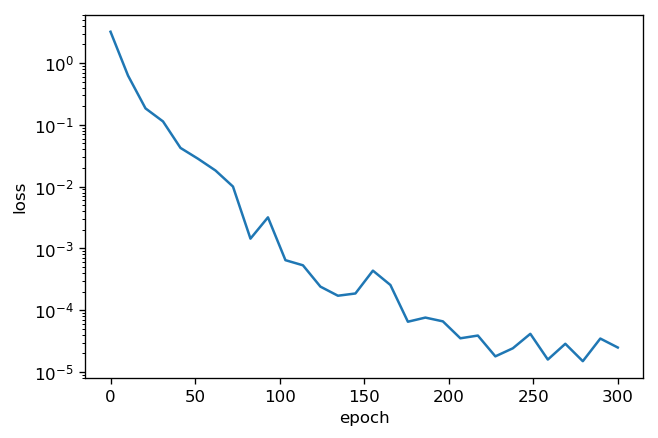

In [77]:
net = get_net(ctx, num_classes=312)
net.hybridize()
train_softmax(train_data, valid_data, net, ctx, num_epoches, 
      learning_rate, lr_decay, lr_period, 
      momentum, weight_decay, cost_period, 
      print_cost=True)

## finetune

In [ ]:
pretrained_net = get_net(ctx=mx.gpu(0), num_classes=64)
pretrained_net.hybridize()
pretrained_net.load_params('fingervein_weight_centerloss_TJ.txt', ctx=mx.gpu(0))

In [ ]:
finetune_net = get_net(ctx=mx.gpu(0), num_classes=492)
finetune_net.hybridize()
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier(), ctx=mx.gpu(0))

In [ ]:
train_center(train_data, valid_data, finetune_net, ctx, num_epoches, 
      learning_rate, lr_decay, lr_period, 
      momentum, weight_decay, cost_period, 
      print_cost=True)

## test accuracy softmax

In [78]:
finetune_net = get_net(ctx, num_classes=312)
finetune_net.hybridize()
finetune_net.load_params('fingervein_weight_softmax_PolyU_new.txt', ctx = ctx)

In [79]:
valid_acc = 0
for data, label in valid_data:
    data = data.as_in_context(ctx)
    label = label.astype('float32').as_in_context(ctx)
    output, features = finetune_net(data)
    valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
print(valid_acc/len(valid_data))

0.958333333333


In [80]:
transform_train = transforms.Compose([
#     transforms.RandomFlipLeftRight(),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomBrightness(0.1), 
#     transforms.RandomContrast(0.1), 
    transforms.Resize(224), 
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [81]:
data_dir = './data/PolyU/'
batch_size = 8

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = DataLoader(train_ds.transform_first(transform_train), 
                        batch_size, shuffle=False, last_batch='keep')
valid_data = DataLoader(valid_ds.transform_first(transform_valid), 
                        batch_size, shuffle=False, last_batch='keep')

In [82]:
print(len(valid_ds))

print(len(valid_data))
for data, label in valid_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

936
117
(8, 3, 224, 224) (8,)

[0 0 0 1 1 1 2 2]
<NDArray 8 @gpu(0)>


In [83]:
fingervein_net = get_net(ctx=mx.gpu(0), num_classes=312)
fingervein_net.hybridize()
fingervein_net.load_params('fingervein_weight_softmax_PolyU_new.txt', ctx=mx.gpu(0))

In [84]:
tr_features = np.zeros((936, 1792))
tr_labels = np.zeros((936))
i = 0
for data, label in train_data:
    data = data.as_in_context(mx.gpu(0))
#             label = label.as_in_context(ctx)
    label = label.astype('float32').as_in_context(mx.gpu(0))
    output, features = fingervein_net(data)
#     print(features.shape)
    features = features.asnumpy()
    label = label.asnumpy()
#     print(features.shape)
    if i+8 > 936:
        tr_features[i:936, :] = features
        tr_labels[i:936] = label
    else:
        tr_features[i:i+8, :] = features
        tr_labels[i:i+8] = label
        i+=8

In [85]:
print(tr_labels[935])

311.0


In [86]:
te_features = np.zeros((936, 1792))
te_labels = np.zeros((936))
i = 0
for data, label in valid_data:
    data = data.as_in_context(mx.gpu(0))
#             label = label.as_in_context(ctx)
    label = label.astype('float32').as_in_context(mx.gpu(0))
    output, features = fingervein_net(data)
#     print(features.shape)
    features = features.asnumpy()
    label = label.asnumpy()
#     print(features.shape)
    if i+8 > 936:
        te_features[i:936, :] = features
        te_labels[i:936] = label
    else:
        te_features[i:i+8, :] = features
        te_labels[i:i+8] = label
        i+=8

In [87]:
print(te_features.shape)

(936, 1792)


In [88]:
def fingervein_dist(f1,f2,w=1):
    if w == 1:
        w = np.ones(f1.shape)
    if len(f1.shape) == len(f2.shape) == 1:
        dist = np.linalg.norm((f1-f2)*w)
    else:
        dist = np.linalg.norm((f1-f2)*w, axis=1)
    return dist

In [89]:
def distance_based_prediction(FingerveinEmbedding, train_Labels, f):
    
    Dists = fingervein_dist(FingerveinEmbedding, f)
    
    i = np.argmin(Dists)
    
    return train_Labels[i]

In [90]:
# test accuracy
nCorrect = 0
ntest = te_features.shape[0]
for i in range(ntest):
    p = distance_based_prediction(tr_features, tr_labels, te_features[i])
    if p == te_labels[i]:
        nCorrect += 1
print('Fingervein recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/ntest))

Fingervein recognition accuracy using purely distance based method: 96.047 %


In [91]:
print(nCorrect)

899


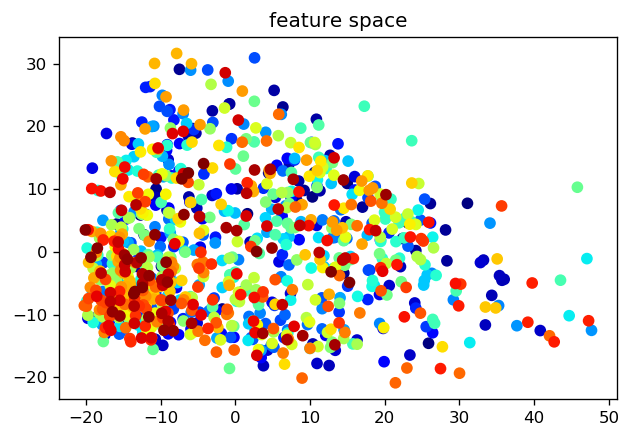

In [92]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(tr_features)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=tr_labels, cmap='jet')
plt.title('feature space')
plt.legend()
plt.savefig('feature space -softmax-loss PolyU new.png')

<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<input>:28: DeprecationWarning: invalid escape sequence \-
<input>:29: DeprecationWarning: invalid escape sequence \-
<ipython-input-93-82e3b76b3067>:28: DeprecationWarning: invalid escape sequence \-
  print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
<ipython-input-93-82e3b76b3067>:29: DeprecationWarning: invalid escape sequence \-
  print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))


Cross-class distance = 17.475 +\- 2.099
Same-class distance = 7.701 +\- 2.946


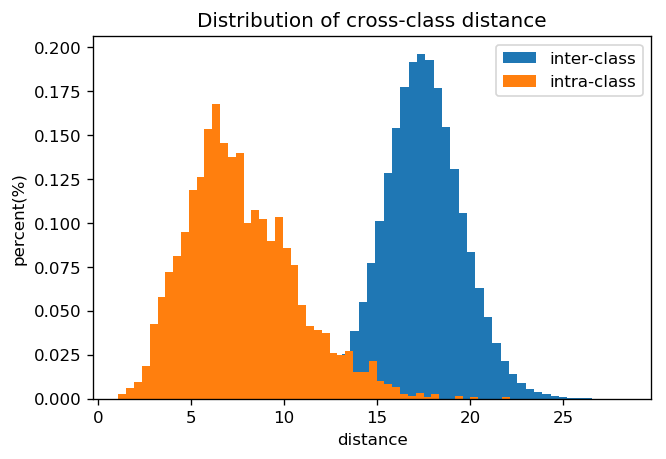

In [93]:
Distances_within_class = []
Distances_among_class = []

ntrain = tr_features.shape[0]
ntest = te_features.shape[0]

for i in range(ntest):
    for j in range(ntrain):
        cur_dist = fingervein_dist(tr_features[j,:],te_features[i,:])
        if te_labels[i] == tr_labels[j]:
            Distances_within_class.append(cur_dist)
        else:
            Distances_among_class.append(cur_dist)
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)


plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'inter-class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'intra-class', normed = True)
plt.title('Distribution of cross-class distance')
plt.xlabel('distance')
plt.ylabel('percent(%)')
plt.legend()
plt.savefig('Distribution of cross-class distance softmax-loss -PolyU new.png')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

EER =  3.64066608038
pct of false positive 0.000 %
pct of false negative 100.000 %
accuracy = 99.679


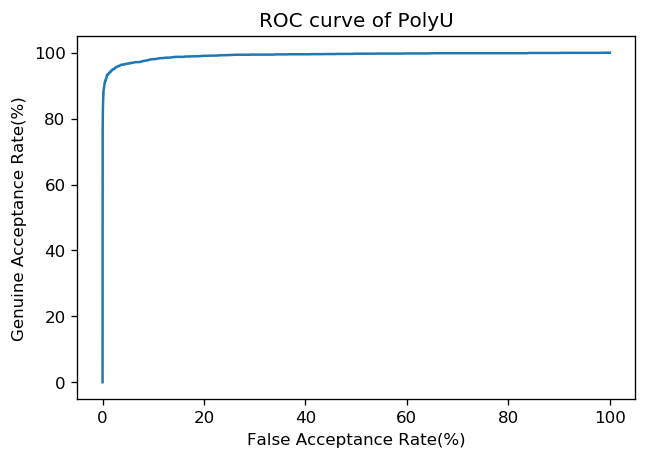

In [96]:
FP = []
FN = []
GAR = []
EER = 0
for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    if np.abs((100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)) - (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))) < 0.05:
        print("EER = ",0.5* (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)+100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))
GAR = FN
for i, value in enumerate(FN):
    GAR[i] = 100 - FN[i]
                                                                
plt.plot(FP,GAR)
plt.xlabel('False Acceptance Rate(%)')
plt.ylabel('Genuine Acceptance Rate(%)')
plt.title('ROC curve of PolyU')
plt.savefig('ROC curve -softmax-loss -PolyU new.png')
threshold = 0.3
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [ ]:
a = [1, 2, 3]
for i, value in enumerate(a):
    a[i] -= 3

In [ ]:
a